In [1]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

plt.style.use('ggplot')

# Gaussian Naive Bayes

In [2]:
df = sns.load_dataset('iris')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
df.species.value_counts()

setosa        50
versicolor    50
virginica     50
Name: species, dtype: int64

In [4]:
# Membuang elemen yang tidak kita gunakan
del df['sepal_length']
del df['sepal_width']
# Menghitung nilai MLE mean dan std untuk distribusi Gaussian petal_length dan petal_width
df.groupby('species').aggregate(['mean', 'std', 'min', 'max'])

petal_length                     petal_width                    
                   mean       std  min  max        mean       std  min  max
species                                                                    
setosa            1.462  0.173664  1.0  1.9       0.246  0.105386  0.1  0.6
versicolor        4.260  0.469911  3.0  5.1       1.326  0.197753  1.0  1.8
virginica         5.552  0.551895  4.5  6.9       2.026  0.274650  1.4  2.5

Perhitungan rata-rata dan variansi dari r.v. `petal_length` dan `petal_width` untuk distribusi Gaussian dapat dilakukan dengan:
$$
\hat{\mu}_{l,setosa} = \frac{1}{50} \sum_{i;y=setosa} l_i
$$
$$
\hat{\sigma}_{l,setosa}^2 = \frac{1}{50} \sum_{i;y=setosa} (l_i - \hat{\mu}_{l,setosa})^2
$$
$$
\hat{\mu}_{w,setosa} = \frac{1}{50} \sum_{i;y=setosa} w_i
$$
$$
\hat{\sigma}_{w,setosa}^2 = \frac{1}{50} \sum_{i;y=setosa} (w_i - \hat{\mu}_{w,setosa})^2
$$

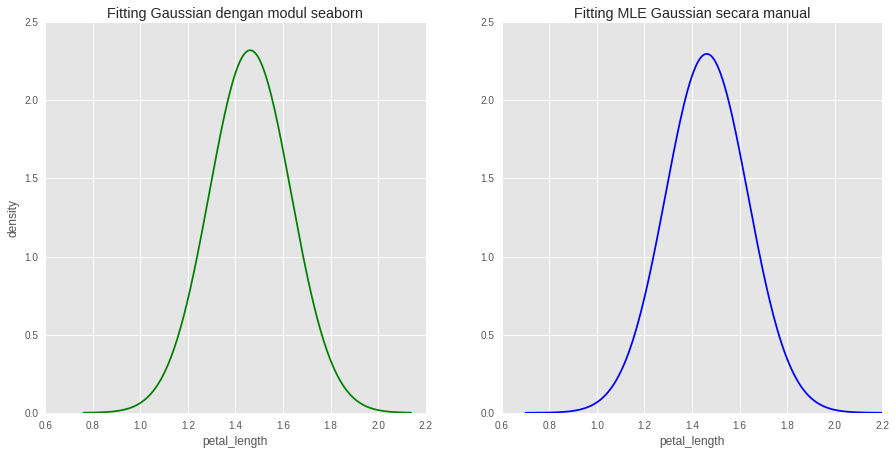

In [5]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
sns.distplot(df[df.species == 'setosa'].petal_length, kde=False, fit=norm, hist=False, fit_kws={'color': 'g'}, ax=ax[0])
ax[0].set_ylabel('density')
ax[0].set_title('Fitting Gaussian dengan modul seaborn')

ax[1].set_title('Fitting MLE Gaussian secara manual')
x = np.linspace(0.7, 2.2, 300) # membuat nilai dari [0.7, 2.2] yang dibagi menjadi 300 titik
mu_setosa = df[df.species == 'setosa'].petal_length.mean()
std_setosa = df[df.species == 'setosa'].petal_length.std()
ax[1].plot(x, norm.pdf(x, mu_setosa, std_setosa), color='b')
ax[1].set_xlabel('petal_length')
plt.show()

![Gaussian MLE](http://uai.aliakbars.com/images/mle.gif)

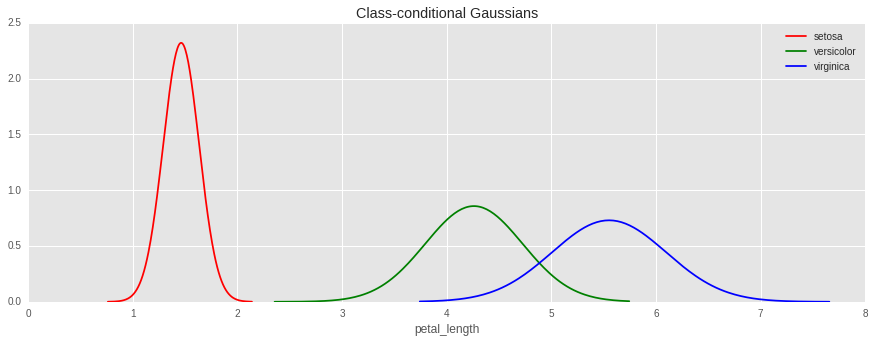

In [6]:
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(df[df.species == 'setosa'].petal_length, kde=False, hist=False, fit=norm, fit_kws={'color': 'r', 'label': 'setosa'}, ax=ax)
sns.distplot(df[df.species == 'versicolor'].petal_length, kde=False, hist=False, fit=norm, fit_kws={'color': 'g', 'label': 'versicolor'}, ax=ax)
sns.distplot(df[df.species == 'virginica'].petal_length, kde=False, hist=False, fit=norm, fit_kws={'color': 'b', 'label': 'virginica'}, ax=ax)
plt.title('Class-conditional Gaussians')
plt.legend()
plt.show()

# Bernoulli Naive Bayes

In [7]:
df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


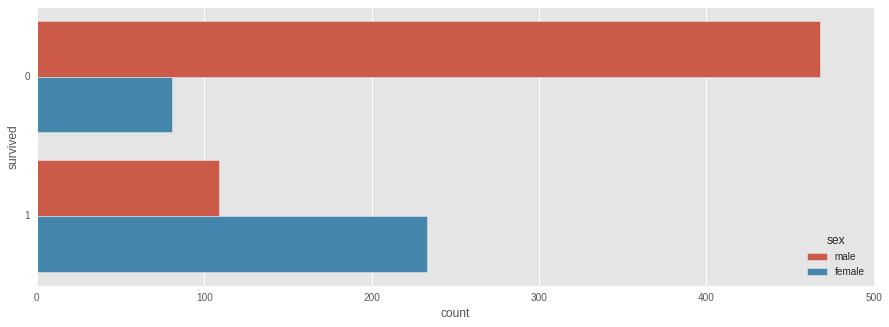

In [8]:
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(y='survived', hue='sex', data=df, ax=ax)
plt.show()

In [9]:
sex = pd.crosstab(df.sex, df.survived, margins=True).apply(lambda x: x/float(x[-1]))
sex

survived,0,1,All
sex,,,
female,0.147541,0.681287,0.352413
male,0.852459,0.318713,0.647587
All,1.000000,1.000000,1.000000


Perhitungan di atas menunjukkan:

$P(male|survived) = 0.318713$

$P(female|survived) = 0.681287$

$P(male|dead) = 0.852459$

$P(female|dead) = 0.147541$

dengan kata lain, kita akan lebih mungkin menemukan wanita dari para penyintas (_survivor_). Dalam Bernoulli NB, kita akan melakukan perhitungan probabilitas seperti ini untuk tiap pasangan atribut dengan kelas (karena asumsi _class-conditional independence_).

In [10]:
alone = pd.crosstab(df.alone, df.survived, margins=True).apply(lambda x: x/float(x[-1]))
print alone
alone[1][False] # cara mengakses: dataframe[kelas][atribut]

survived         0         1       All
alone                                 
False     0.318761  0.523392  0.397306
True      0.681239  0.476608  0.602694
All       1.000000  1.000000  1.000000


0.52339181286549707

Untuk Bernoulli NB dengan dua variabel (`sex` dan `alone` saja), maka probabilitasnya menjadi:

$$
P(survived|sex,alone) = \frac{P(sex,alone|survived)P(survived)}{P(sex,alone)}
$$
$$
P(survived|sex,alone) = \frac{P(sex|survived)P(alone|survived)P(survived)}{\sum_{survived \in \{0,1\}} P(sex|survived)P(alone|survived)P(survived)}
$$